# Il Grafo delle Sovrapposizioni e la *Shortest Common Superstring*

Il *grafo delle sovrapposizioni* (*overlap graph*) è una struttura che ci può servire per assemblare delle read
prodotte da un sequenziatore. Ogni nodo del grafo rappresenta una stringa e gli archi *orientati*
rappresentano la sovrapposizioni del suffisso del nodo sorgente al prefisso del nodo destinazione.

La superstringa comune più corta (*shortest common superstring* (SCS)) di un insieme di stringe $S$
è la stringa più corta che include tra le sue sottostringe tutte le stringhe in $S$. Quando il grafo
delle sovrapposizioni è popolato con le read prodotte da un sequenziatore la SCS corrisponde a una sequenza
assemblata.

La funzione `get_overlap()` ci servirà a calcolare la lunghezza della sovrapposizione tra 
la parte terminale e quella iniziale di due stringhe. Invece, la funzione `get_kmers()` restituirà
una lista contenente tutti i k-meri di una stringa.

In [1]:
# importo i tipi per fare inferenza dei tipi (non necessaria)
from typing import List, Iterable, Tuple

In [2]:
def get_overlap(a: str, b: str, min_length: int = 3) -> int:
    """Calcola la sovrapposizione tra due stringhe

    Questa funzione calcola la lunghezza del suffisso più lungo
    di una stringa a che è prefisso di un'altra stringa b.
    """

    # per tutti gli start tra min_length e len(a)-1
    for start in range(0, len(a)-min_length+1):
        # se b inizia con il suffisso di lunghezza len(a)-start
        if b.startswith(a[start:]):
            return len(a)-start

    # non c'è un allineamento
    return 0

def get_kmers(string: str, k: int) -> List[str]:
    """Suddivide una stringa nei suoi k-meri

    Questa funzione calcola le sottostringhe contigue
    di una stringa di lunghezza k.
    """
    kmers = []
    for i in range(len(string)-k+1):
        kmers.append(string[i:i+k])

    return kmers

Calcolare la SCS di un insieme $S$ di stringhe è un problema [NP-completo](https://it.wikipedia.org/wiki/NP-completo). Perciò il migliore algorimo conosciuto che svolge tale compito itera su tutte le possibili permutazione degli elementi in $S$ e cerca la permutazione le cui sovrapposizioni di elementi successivi generi la stringa di lunghezza minima. Il seguente algoritmo implementa l'algoritmo descritto.

In [3]:
# importo la funzione permutations dal pacchetto itertools
from itertools import permutations

def get_SCS(reads: Iterable[str]) -> str:
    """Calcola la superstringa comune più corta di un insieme di stringhe

    Questa funzione prende un iterabile di stringhe e trova la
    superstringa comune più corta (SCS).
    """

    candidate = None

    # per tutte le permutazioni delle read
    for o_reads in permutations(reads):

        # costruisco la superstringa più corta che 
        # rispetta la permutazione 
        ss = o_reads[0]
        for i in range(0, len(reads)-1):
            # per ogni coppia di read consecutive, trovo l'overlap massimo
            o_len = get_overlap(o_reads[i], o_reads[i+1], 1)

            # aggiungo il suffisso della seconda read che non è 
            # contenuto nella read precedente
            ss += o_reads[i+1][o_len:]

        # se la superstringa trovata è più corta della SCS candidata
        if candidate is None or len(ss) < len(candidate):
            candidate = ss

    return candidate

Prendiamo in considerazione una stringa e testiamo la funzione `get_SCS()` su un numero limitato dei suoi k-meri.

In [4]:
DNA = "GTTAATGTCCGATGGTCAAGGAT"
kmers_len = 17

# stampo la seguenza di DNA e la sua lunghezza
print(f"La stringa originale è \"{DNA}\" ed ha lunghezza {len(DNA)}.")

La stringa originale è "GTTAATGTCCGATGGTCAAGGAT" ed ha lunghezza 23.


In [5]:
# simulo le read costruendo i k-meri della sequenza
kmers = get_kmers(DNA, kmers_len)

# stampo le reads
print(f"I suoi {kmers_len}-meri sono {kmers}.")

I suoi 17-meri sono ['GTTAATGTCCGATGGTC', 'TTAATGTCCGATGGTCA', 'TAATGTCCGATGGTCAA', 'AATGTCCGATGGTCAAG', 'ATGTCCGATGGTCAAGG', 'TGTCCGATGGTCAAGGA', 'GTCCGATGGTCAAGGAT'].


In [6]:
# calcolo la SCS
SCS = get_SCS(kmers)

print(f"\"{SCS}\" è la SCS di {kmers}.")


print("La SCS è " + ("uguale" if SCS == DNA else "diversa") + " dalla stringa originale.")

"GTTAATGTCCGATGGTCAAGGAT" è la SCS di ['GTTAATGTCCGATGGTC', 'TTAATGTCCGATGGTCA', 'TAATGTCCGATGGTCAA', 'AATGTCCGATGGTCAAG', 'ATGTCCGATGGTCAAGG', 'TGTCCGATGGTCAAGGA', 'GTCCGATGGTCAAGGAT'].
La SCS è uguale dalla stringa originale.


Se provassimo a eseguire `get_SCS()` sulle $21$ triplette di della stringa, il programma sembrerebbe
non terminare. Perché? Calcolare la SCS prende tempo $O(n!)$, con n numero
di read/nodi del grafo delle sovrapposizioni. Quindi non riusciamo a 
calcolare SCS nemmeno per n relativamente piccoli, e.g., trovare la SCS di 
20 stringhe richiede $20!$ (circa $2.5*10^{18}$) passi.

Sfortunatamente, non è un problema implementativo o algoritmico. Il problema è "difficile" di per se e non si sa se esistano algoritmi più performanti.

In [7]:
# Sostituisci True a False per provare a calcolare la SCS delle 21 triplette di DNA
if False:
    # trovo i k-meri di dimensione 3
    kmers3 = get_kmers(DNA, 3)
    print(f"\"{DNA}\" contiene {len(kmers3)} triplette.")

    # calcolo la SCS delle 21 triplette della stringa DNA
    SCS3 = get_SCS(kmers3)

    print(f"\"{SCS3}\" è la SCS di {kmers3}.")

# L'Algoritmo Greedy per la *Shortest Common Superstring*

Cercando di avere almeno una risposta approssimativa, ci accontentiamo di usare una 
strategia approssimata: la soluzione non sarà sempre esatta, ma almeno avremmo una risposta 
"vicina" a quella corretta breve tempo.

L'algoritmo greedy opera come segue:
1. trova *un* arco $(a, b)$ rappresentante una sovrapposizione di lunghezza massimale
2. collassa i nodi $a$ e $b$ in un nodo $c$ rappresentante la stringa in cui $b$ è sovrapposto al suffisso di $a$
3. ripeti dal punto 1. fino a quando la sovrapposizione massimale è maggiore di una lunghezza fissata
4. concatena le stringhe rimanenti

Il metodo `get_maximal_overlap()` trova un arco con sovrapposizione di lunghezza massimale. Il metodo `get_greedy_SCS()` implementa l'algoritmo descritto.

In [8]:
from typing import Tuple

def get_maximal_overlap(reads: Iterable[str], k: int) -> Tuple[str, str, int]:
    """Individua una sovrapposizione massimale
    
    Questa funzione individua in un insieme di read una coppia di read
    tra cui c'è una sovrapposizione massimale. La funzione restituisce 
    la coppia read e la lunghezza della loro sovrapposizione."""

    # best_* conterrano i candidati a,b, e lunghezza dell'overlap a-b
    best_a, best_b, best_o = None, None, 0

    # per tutte le coppie ordinate di read diverse
    for a,b in permutations(reads, 2):

        # calcolo la lunghezza della loro sovrapposizione
        o_len = get_overlap(a, b, k)

        # se la sovrapposizione è più lungha della candidata massimale
        if best_o <= o_len:

            # aggiorno i candidati
            best_a, best_b, best_o = a, b, o_len

    return best_a, best_b, best_o

def get_greedy_SCS(reads: Iterable[str], min_len:int = 1) -> str:
    """Calcola la superstringa comune più corta usando l'algoritmo greedy

    Questa funzione prova a calcolare la superstringa comune più corta di
    un insieme di reads usando l'algoritmo greedy. Fino a quando il grafo
    delle sovrappozioni ha almeno una sovrappozione di lunghezza `min_len`,
    trovo una sovrappozione di lunghezza massimale e faccio collassare le
    stringhe corrispondente.
    """

    # copio l'insieme delle read per evitare di modificare il parametro
    # attuale della chiamata (reads)
    r_copy = [read for read in reads]

    # trovo l'arco con la sovrapposizione massimale
    a, b, o_len = get_maximal_overlap(r_copy, min_len)

    # fino a quando la sovrapposizione massimale ha almeno lunghezza k
    while o_len>=min_len:
        # aggiorno il grafo rimuovendo a e b
        r_copy.remove(a)
        r_copy.remove(b)

        # aggiorno il grafo aggiungendo la giustappozione tra a e il 
        # suffisso di b che non fa parte della sovrapposizione tra a e b
        r_copy.append(a+b[o_len:])

        # trovo un nuovo arco con la sovrapposizione massimale
        a, b, o_len = get_maximal_overlap(r_copy, min_len)

    # concatena le stringhe che non hanno sovrapposizioni di lunghezza
    # almeno min_len
    return ''.join(r_copy)

Testiamo la funzione `get_greedy_SCS()` sui 17-meri della stringa DNA.

In [9]:
# calcolo la SCS utilizzando l'algoritmo greedy
greedy_SCS = get_greedy_SCS(kmers)

print(f"\"{SCS}\" è la SCS trovata usando l'algoritmo esatto.")
print(f"\"{greedy_SCS}\" è la SCS trovata usando l'algoritmo greedy.")

print("Le due stringhe sono " + ("uguali" if SCS == greedy_SCS else "diverse"))

"GTTAATGTCCGATGGTCAAGGAT" è la SCS trovata usando l'algoritmo esatto.
"GTTAATGTCCGATGGTCAAGGAT" è la SCS trovata usando l'algoritmo greedy.
Le due stringhe sono uguali


Testiamo ora `get_greedy_SCS()` sulle quadruple della stringa DNA.

In [10]:
# trovo i k-meri di dimensione 4
kmers = get_kmers(DNA, 4)

# calcolo la SCS utilizzando l'algoritmo greedy
greedy_SCS = get_greedy_SCS(kmers)

print(f"\"{SCS}\" è la SCS trovata usando l'algoritmo esatto.")
print(f"\"{greedy_SCS}\" è la SCS trovata usando l'algoritmo greedy.")

print("Le due stringhe sono " + ("uguali" if SCS == greedy_SCS else "diverse"))

"GTTAATGTCCGATGGTCAAGGAT" è la SCS trovata usando l'algoritmo esatto.
"GGATGGTCAAGGAGTTAATGTCCGAT" è la SCS trovata usando l'algoritmo greedy.
Le due stringhe sono diverse


L'algoritmo greedy ottiene una soluzione in breve tempo, ma la soluzione è non esatta.

# Disegnare il Grafo delle Sovrapposizioni

Il grafo delle sovrapposizioni non è rappresentato esplicitamente in `get_SCS()` e `get_greedy_SCS()`. Tuttavia, per motivi didattici, ci potrebbe fare comodo visualizzarlo. La seguente classe consente la costruzione e la visualizzazione di oggetti di questo tipo. 

In [11]:
# importo dei pacchetti per disegnare il grafo delle sovrapposizioni
import networkx as nx
import matplotlib.pyplot as plt

class OverlapGraph(nx.DiGraph):
    """Grafo di sovrapposizione

    Questa classe rappresenta i grafi di sovrapposizione. Ogni
    nodo è una stringa e ogni arco rappresenta la sovrapposizione
    del suffisso della sorgente con il prefisso della destinazione.
    """

    def __init__(self, reads: Iterable[str], min_length: int):
        """Costrusci di un grafo di sovrapposizione
        
        Questo metodo costruisce un nuovo grafo di sovrapposizione
        aggiungendo archi di peso minimo k.
        """

        # inizializziamo l'oggetto del tipo nx.DiGraph
        super().__init__()
   
        # per ogni coppia ordinata di nodi diversi
        for a,b in permutations(reads, 2):

            # calcolo la sovrapposizione 
            o_len = get_overlap(a, b, min_length)

            # se è lunga almeno min_length
            if o_len >= min_length:
                # aggiungo l'arco tra a e b
                self.add_edge(a, b, ovelap=o_len)

    def plot(self):
        """Disegna un grafo di sovrappozione"""

        # trova la posizione dei nodi e degli archi
        pos = nx.kamada_kawai_layout(self)

        # disegna i nodi
        nx.draw(self, pos, with_labels=True, arrows=True)

        # estrai l'attributo degli archi "overlap" 
        edge_labels = nx.get_edge_attributes(self, "ovelap")

        # disegna gli archi e le etichette "overlap"
        nx.draw_networkx_edge_labels(self, pos,
                                           edge_labels=edge_labels)

        # mostra il disegno
        plt.show()

Proviamo a disegnare il grafo delle sovrapposizioni degli 7-meri della stringa DNA tenendo conto solamente delle sovrapposizioni di lunghezza maggiore a 4.

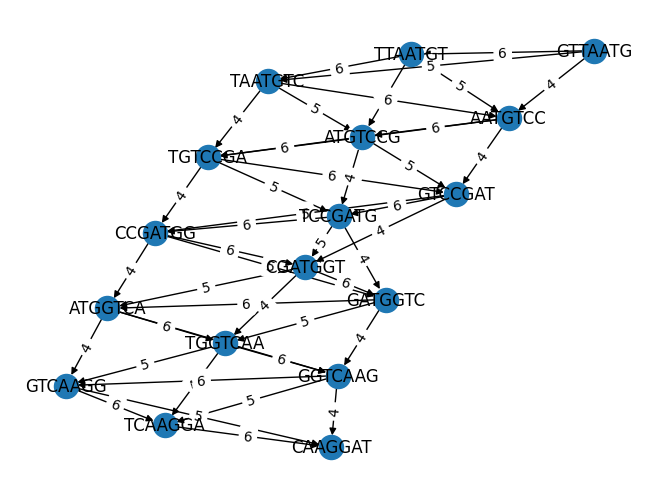

In [12]:
# trovo i k-meri di dimensione 7
kmers = get_kmers(DNA, 7)

# costruisco il grafo delle sovrapposizioni degli 7-meri
# tenendo conto solamente delle sovrapposizioni di lunghezza
# maggiore o uguale a 4
G = OverlapGraph(kmers, min_length=4)

# disegno il grafo
G.plot()